# Converting an ANN to an SNN

This tutorial walks you through how to convert your pre-trained model to a spiking version.
Lets start by installing all the necessary packages. 

## Defining an ANN
We define a simple convolutional architecture.

In [1]:
import os                        # check our work directory
import numpy as np               # lib for algebra/numerical 
import pandas as pd              # lib for data load or save
import sklearn                   # lib for ML and filters
import PIL                       # lib for Imaging tasks
import glob                      # lib to return file paths 
#import pyedflib                  # lib to read EDF files
import warnings                  # lib to deal with warnings

import torch                     # lib for pytorch
import torch.nn as nn            # pytorch NNs
import torchvision               # lib for vision
import torch.optim as optim      # pytorch optimizers i.e. SGD, Adam
import torch.nn.functional as F  # pytorch functions
import matplotlib.pyplot as plt  # visualize datasets

from PIL import Image                                 # python Imaging Library
from scipy import signal                              # import signal from scipy
from torchvision import datasets, models, transforms  # to laod standard datasets 
from torch.utils.data import DataLoader, Dataset      # to perform transformations on dataset
from torchvision.transforms import ToTensor           # to convert numpy array to tensor
from sklearn.model_selection import train_test_split  # train test split function
from scipy.signal import butter, lfilter, sosfilt, sosfreqz
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, fbeta_score

warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
       
class Conv_Net(nn.Module):
    def __init__(self):
        super(Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(1,8), stride=(1, 1), padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 8))
        self.bnrm1 = nn.BatchNorm2d(4)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(4, 16, kernel_size=(1, 16), stride=(1, 1), padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 4))
        self.bnrm2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(16, 16, kernel_size=(1, 8), stride=(1, 1), padding=7)   #### 1
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 4))
        self.bnrm3 = nn.BatchNorm2d(16)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(16, 16, kernel_size=(16, 1), stride=(1, 1), padding=0)
        self.pool4 = nn.MaxPool2d(kernel_size=(4, 1), stride=(1, 1), padding=0)
        self.bnrm4 = nn.BatchNorm2d(16)
        self.relu4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(16, 16, kernel_size=(16, 1), stride=(1, 1), padding=0)
        self.pool5 = nn.MaxPool2d(kernel_size=(4, 1), stride=(1, 1), padding=0)
        self.bnrm5 = nn.BatchNorm2d(16)
        self.relu5 = nn.ReLU()
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.15)
        
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 2)     #1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bnrm1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bnrm2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bnrm3(x)
        x = self.relu3(x)
        
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.bnrm4(x)
        x = self.relu4(x)
            
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.bnrm5(x)
        x = self.relu5(x)
        
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

In [3]:
os.listdir('E:\York\RA ship\code\SINABS\chb02_img2')

['chb02_16_time_nonseizure_0.jpg',
 'chb02_16_time_nonseizure_1.jpg',
 'chb02_16_time_nonseizure_66.jpg',
 'chb02_16_time_nonseizure_67.jpg',
 'chb02_16_time_nonseizure_68.jpg',
 'chb02_16_time_nonseizure_69.jpg',
 'chb02_16_time_nonseizure_70.jpg',
 'chb02_16_time_nonseizure_71.jpg',
 'chb02_16_time_nonseizure_72.jpg',
 'chb02_16_time_nonseizure_73.jpg',
 'chb02_16_time_nonseizure_74.jpg',
 'chb02_16_time_nonseizure_75.jpg',
 'chb02_16_time_nonseizure_76.jpg',
 'chb02_16_time_nonseizure_77.jpg',
 'chb02_16_time_nonseizure_78.jpg',
 'chb02_16_time_nonseizure_79.jpg',
 'chb02_16_time_nonseizure_80.jpg',
 'chb02_16_time_nonseizure_81.jpg',
 'chb02_16_time_nonseizure_82.jpg',
 'chb02_16_time_nonseizure_83.jpg',
 'chb02_16_time_nonseizure_84.jpg',
 'chb02_16_time_nonseizure_85.jpg',
 'chb02_16_time_nonseizure_86.jpg',
 'chb02_16_time_nonseizure_87.jpg',
 'chb02_16_time_nonseizure_88.jpg',
 'chb02_16_time_nonseizure_89.jpg',
 'chb02_16_time_nonseizure_90.jpg',
 'chb02_16_time_nonseizure_91.

In [4]:
%cd /local/data0/amuneeb/proj/chb-mit/chb_02/chb02_img2/

[WinError 3] The system cannot find the path specified: '/local/data0/amuneeb/proj/chb-mit/chb_02/chb02_img2/'
e:\York\RA ship\code\SINABS


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)     
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [6]:
data_dir = 'E:\York\RA ship\code\SINABS\chb02_img2'

In [7]:
os.listdir(data_dir)[:5]

['chb02_16_time_nonseizure_0.jpg',
 'chb02_16_time_nonseizure_1.jpg',
 'chb02_16_time_nonseizure_66.jpg',
 'chb02_16_time_nonseizure_67.jpg',
 'chb02_16_time_nonseizure_68.jpg']

In [8]:
data_list = glob.glob(os.path.join(data_dir,'*.jpg'))

In [9]:
# dataset split to train & test data
train_list, test_list = train_test_split(data_list, test_size=0.2)

In [10]:
print("train_data = " + str(len(train_list)))
print("test_data = "  + str(len(test_list)))

train_data = 6527
test_data = 1632


In [11]:
# train data split to train & validation data
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [12]:
print("train_data = " + str(len(train_list)))
print("val_data = "  + str(len(val_list)))

train_data = 5221
val_data = 1306


In [13]:
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
  print(idx)

19740
20562
6989
17948
11043
15342
16830
20936
6243
12167


<Figure size 432x288 with 0 Axes>

In [14]:
train_list[0]

'E:\\York\\RA ship\\code\\SINABS\\chb02_img2\\chb02_16+_time_nonseizure_2357.jpg'

In [15]:
train_list[0].split('/')[-1].split('.')[0].split('_')[4]

'nonseizure'

In [16]:
test_list[0].split('/')[-1].split('.')[0].split('_')[4]

'nonseizure'

In [17]:
#data transformation

train_transforms =  transforms.Compose([
        transforms.Resize((23, 256)),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((23, 256)),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([   
    transforms.Resize((23, 256)),
    transforms.ToTensor()
    ])


In [18]:
class dataset(torch.utils.data.Dataset):

    def __init__(self, file_list, transform=None, train=True, is_spiking=False, time_window=100):
        self.file_list = file_list
        self.transform = transform
        self.is_spiking = is_spiking
        self.time_window = time_window
        
    # dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    # load one of images
    def __getitem__(self,idx):
        

        img_path = self.file_list[idx]
        img = Image.open(img_path)
        #img = ToTensor()(img)
       
        # print ("AA?>>>>>>>", aa)
        # print ("IMG_Path>>>>>>>", img_path)
        # print ("Image_size>>>>", aa.shape)
        # print ("Image_TYPE>>>>", aa.type())

        # img = self.file_list[idx].unsqueeze(0) / 255
        # img is now a tensor of 1x28x28

        # print ("IMG>>>>>>>", img)
        # print ("Image_size>>>>", img.shape)
        # print ("Image_TYPE>>>>", img.type())



        #img = self.file_list[idx].unsqueeze(0) / 255
        # img_path = self.file_list[idx]
        # img = Image.open(img_path)
        # print ("Image_size>>>>", img.size)
        # print ("Image_size>>>>", type(img))

        img_transformed = self.transform(img)
        
    # pass labels to data
        label = img_path.split('/')[-1].split('.')[0].split('_')[4]
        if label == 'seizure':
            label=1
        elif label == 'nonseizure':
            label=0

        if self.is_spiking:
            img_transformed = (torch.rand(self.time_window, *img_transformed.shape) < img_transformed).float()            
            
        return img_transformed,label        

In [19]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [20]:
batch_size = 32  # mini batch size
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [21]:
print(len(train_data), len(train_loader))

5221 164


In [22]:
print(len(val_data), len(val_loader))

1306 41


In [23]:
# check input data shape
print("Type>>>>>>>>>>>", type(train_data[0][0]))
print("Torch shape>>>>", train_data[0][0].shape)


Type>>>>>>>>>>> <class 'torch.Tensor'>
Torch shape>>>> torch.Size([1, 23, 256])


In [24]:
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

correct_predictions = []
all_targets = []
all_preds = []

device = "cuda" if torch.cuda.is_available() else "cpu"

ann = Conv_Net().to(device)
ann.train()

optim = torch.optim.Adam(ann.parameters(), betas=(0.9, 0.999), eps=1e-03, amsgrad=False, lr=0.0001)

n_epochs = 20

for n in tqdm(range(n_epochs)):
    for data, target in iter(train_loader):
        data, target = data.to(device), target.to(device)
        output = ann(data)
        optim.zero_grad()
        

        loss = F.cross_entropy(output, target)
        loss.backward()
        optim.step()

        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # Compute the total correct predictions
        correct_predictions.append(pred.eq(target.view_as(pred)))
        all_targets.append(target.cpu().numpy())
        all_preds.append(pred.cpu().numpy())

# Calculate the total number of correct predictions and the total number of predictions
correct_predictions = torch.cat(correct_predictions)

total_correct = correct_predictions.sum().item()
total_predictions = len(correct_predictions)

# Calculate the overall accuracy
accuracy = total_correct / total_predictions

# Calculate the confusion matrix
y_true = np.concatenate(all_targets)
y_pred = np.concatenate(all_preds)
cm = confusion_matrix(y_true, y_pred)

#Calculate the sensitivity, specificity, and accuracy
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
# specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

print(f"Classification Accuracy: {accuracy * 100}%")
print(f"Classification Sensitivity: {sensitivity * 100}%")
print(f"Classification Specificity: {specificity * 100}%")

#correct_predictions = torch.cat(correct_predictions)
print(
    f"Classification accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%"
)
        

  0%|          | 0/20 [00:00<?, ?it/s]

Classification Accuracy: 94.59107450679947%
Classification Sensitivity: 6.176470588235294%
Classification Specificity: 96.6532732261858%
Classification accuracy: 94.59107450679947%


In [ ]:
# from tqdm.auto import tqdm
# import torch
# import torch.nn.functional as F
# from sklearn.metrics import confusion_matrix

# correct_predictions = []
# all_targets = []
# all_preds = []

# device = "cuda" if torch.cuda.is_available() else "cpu"

# ann = Conv_Net().to(device)
# ann.train()

# optim = torch.optim.Adam(ann.parameters(), lr=1e-3)

# n_epochs = 20

# for n in tqdm(range(n_epochs)):
#     for data, target in iter(train_loader):
#         data, target = data.to(device), target.to(device)
#         output = ann(data)
#         optim.zero_grad()
        

#         loss = F.cross_entropy(output, target)
#         loss.backward()
#         optim.step()

#         # get the index of the max log-probability
#         pred = output.argmax(dim=1, keepdim=True)

#         # Compute the total correct predictions
#         correct_predictions.append(pred.eq(target.view_as(pred)))
#         all_targets.append(target.cpu().numpy())
#         all_preds.append(pred.cpu().numpy())

# # Calculate the total number of correct predictions and the total number of predictions
# correct_predictions = torch.cat(correct_predictions)

# total_correct = correct_predictions.sum().item()
# total_predictions = len(correct_predictions)

# # Calculate the overall accuracy
# accuracy = total_correct / total_predictions

# # Calculate the confusion matrix
# y_true = np.concatenate(all_targets)
# y_pred = np.concatenate(all_preds)
# cm = confusion_matrix(y_true, y_pred)

# tn, fp, fn, tp = cm.ravel()
# # Calculate the sensitivity, specificity, and accuracy
# # sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
# # specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# sensitivity = (tp) / (tp + fn)
# specificity = (tn) / (tn + fp)
# accuracy1 = (tp + tn) / (tp + tn + fp + fn)

# print(f"Classification Accuracy: {accuracy * 100}%")
# print(f"Classification Accuracy_New: {accuracy1 * 100}%")
# print(f"Classification Sensitivity: {sensitivity * 100}%")
# print(f"Classification Specificity: {specificity * 100}%")

# #correct_predictions = torch.cat(correct_predictions)
# print(
#     f"Classification accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%"
# )
        

In [123]:
correct_predictions = []
all_targets = []
all_preds = []


for data, target in iter(test_loader):
    data, target = data.to(device), target.to(device)
    output = ann(data)

    # get the index of the max log-probability
    pred = output.argmax(dim=1, keepdim=True)

    # Compute the total correct predictions
    correct_predictions.append(pred.eq(target.view_as(pred)))

    # Compute the total correct predictions
    correct_predictions.append(pred.eq(target.view_as(pred)))
    all_targets.append(target.cpu().numpy())
    all_preds.append(pred.cpu().numpy())

# Calculate the total number of correct predictions and the total number of predictions
correct_predictions = torch.cat(correct_predictions)

total_correct = correct_predictions.sum().item()
total_predictions = len(correct_predictions)

# Calculate the overall accuracy
accuracy = total_correct / total_predictions

# Calculate the confusion matrix
y_true = np.concatenate(all_targets)
y_pred = np.concatenate(all_preds)
cm = confusion_matrix(y_true, y_pred)

# Calculate the sensitivity, specificity, and accuracy
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print(f"Test Accuracy: {accuracy * 100}%")
print(f"Test Sensitivity: {sensitivity * 100}%")
print(f"Test Specificity: {specificity * 100}%")


Test Accuracy: 99.63235294117648%
Test Sensitivity: 84.375%
Test Specificity: 99.9375%


******** SINABS *******

In [126]:
from sinabs.from_torch import from_model

input_shape = (1, 23, 256)
num_timesteps = 100  # per sample

sinabs_model = from_model(
    ann, input_shape=input_shape, add_spiking_output=True, synops=False, num_timesteps=num_timesteps
)

In [127]:
sinabs_model.spiking_model

Conv_Net(
  (conv1): Conv2d(1, 4, kernel_size=(1, 8), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0, dilation=1, ceil_mode=False)
  (bnrm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): IAFSqueeze(spike_threshold=1.0, min_v_mem=-1.0, batch_size=-1, num_timesteps=100)
  (conv2): Conv2d(4, 16, kernel_size=(1, 16), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
  (bnrm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): IAFSqueeze(spike_threshold=1.0, min_v_mem=-1.0, batch_size=-1, num_timesteps=100)
  (conv3): Conv2d(16, 16, kernel_size=(1, 8), stride=(1, 1), padding=(7, 7))
  (pool3): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
  (bnrm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): IAFSqueeze(spike_threshold=1.0, min_

In [136]:
test_batch_size = 8

spike_data_test = dataset(
    train_list, transform=train_transforms, train=False, is_spiking=True, time_window=num_timesteps
)
spike_test_loader = DataLoader(
    spike_data_test, batch_size=test_batch_size, shuffle=True
)

In [137]:
# (Batch, Time, Channels, Height, Width)
data1 = torch.rand(test_batch_size, num_timesteps, 1, 23, 256)

# Data reshaped to fit the flattened model definition
data = data1.view(test_batch_size * num_timesteps, 1, 23, 256)

print(data1.shape)
print(data.shape)


torch.Size([8, 100, 1, 23, 256])
torch.Size([800, 1, 23, 256])


In [138]:
correct_predictions = []
all_targets = []
all_preds = []

import sinabs.layers as sl

correct_predictions = []

for data, target in tqdm(spike_test_loader):
    data, target = data.to(device), target.to(device)
    data = sl.FlattenTime()(data)
    with torch.no_grad():
        output = sinabs_model(data)
        output = output.unflatten(
            0, (test_batch_size, output.shape[0] // test_batch_size)
        )

    # get the index of the max log-probability
    pred = output.sum(1).argmax(dim=1, keepdim=True)

    # Compute the total correct predictions
    correct_predictions.append(pred.eq(target.view_as(pred)))
    all_targets.append(target.cpu().numpy())
    all_preds.append(pred.cpu().numpy())

    if len(correct_predictions) * test_batch_size >= 4500:
        break

# Calculate the total number of correct predictions and the total number of predictions
correct_predictions = torch.cat(correct_predictions)

total_correct = correct_predictions.sum().item()
total_predictions = len(correct_predictions)

# Calculate the overall accuracy
accuracy = total_correct / total_predictions

# Calculate the confusion matrix
y_true = np.concatenate(all_targets)
y_pred = np.concatenate(all_preds)
cm = confusion_matrix(y_true, y_pred)

# Calculate the sensitivity, specificity, and accuracy
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print(f"Test Accuracy: {accuracy * 100}%")
print(f"Test Sensitivity: {sensitivity * 100}%")
print(f"Test Specificity: {specificity * 100}%")


print(
    f"Classification accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%"
)

  0%|          | 0/653 [00:00<?, ?it/s]

Test Accuracy: 97.71314387211368%
Test Sensitivity: 0.0%
Test Specificity: 99.93188010899182%
Classification accuracy: 97.71314387211368%


In [148]:
output_spike_raster = output.view(test_batch_size, num_timesteps, 2)
print(output_spike_raster.shape)

torch.Size([8, 100, 2])


In [33]:
# Get one sample from the dataloader
img, label = spike_data_test[10]

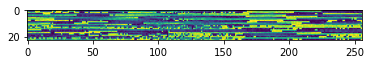

In [34]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.imshow(img.sum(0)[0]);

In [35]:
snn_output = sinabs_model(img.to(device))

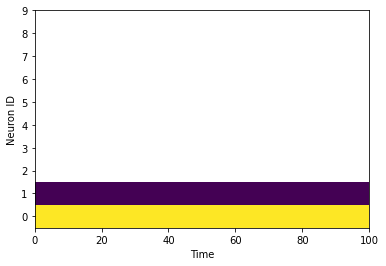

In [36]:
import numpy as np

plt.pcolormesh(snn_output.T.detach().cpu())

plt.ylabel("Neuron ID")
plt.yticks(np.arange(10) + 0.5, np.arange(10))
plt.xlabel("Time");